In [1]:
import torch
import torch.nn as nn 
import torchvision
import numpy as np 
import matplotlib.pyplot as plt 
from torchvision.datasets import ImageFolder
%matplotlib inline
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms

C:\Users\Samba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Samba\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device, torch.cuda.get_device_name()

(device(type='cuda', index=0), 'NVIDIA GeForce GTX 1050')

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

In [4]:
train_ds = ImageFolder('mnist_png/training',transform=transform)
test_ds = ImageFolder('mnist_png/testing',transform=transform)

In [5]:
print('Training samples',len(train_ds) ,'\ntesting samples',len(test_ds))

Training samples 60000 
testing samples 10000


In [6]:
train_ds.classes ==test_ds.classes,train_ds.classes ,test_ds.classes

(True,
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

label 0


(<matplotlib.image.AxesImage at 0x1b02e2e1880>, None)

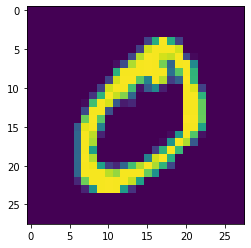

In [7]:
image,label = train_ds[0]
plt.imshow(image.permute(1,2,0)), print(f'label {label}')

In [8]:
image.permute(1,2,0).shape , image.shape , image.size()

(torch.Size([28, 28, 1]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

Dataloader

In [9]:
test,val = torch.utils.data.random_split(train_ds,[42000,18000])
print(len(test),'\n',len(val))
train_loader = DataLoader(test,batch_size = 32,shuffle=True)
val_loader = DataLoader(val,batch_size = 32,shuffle=True)

42000 
 18000


In [10]:
class Lnet(nn.Module):
    def __init__(self):
        super(Lnet,self).__init__()
        self.conv1 = nn.Conv2d(1,20,5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.relu1 = nn.ReLU()
        # 12 x12 x6
        self.conv2 = nn.Conv2d(20,50,5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.relu2 = nn.ReLU()
        # 4x4 x 50
        self.fc1 = nn.Linear(16*50,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x1 = x.view(-1,16*50)
        x = nn.functional.relu(self.fc1(x1))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = torch.softmax(x,dim=0)
        return x

In [11]:
model = Lnet()
model.to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
         MaxPool2d-2           [-1, 20, 12, 12]               0
              ReLU-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
         MaxPool2d-5             [-1, 50, 4, 4]               0
              ReLU-6             [-1, 50, 4, 4]               0
            Linear-7                  [-1, 120]          96,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 132,704
Trainable params: 132,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.51
Estimated Total Size (MB): 0.68
-------------------------------------------

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

In [13]:
trainsteps = len(train_loader.dataset)//32
trainsteps

1312

In [14]:
len(train_loader)

1313

In [15]:
from tqdm.notebook import tqdm
h={ "train_loss":[],'train_acc':[],'val_loss':[],'val_acc':[]}
for i in range(10):
    print('Training epoch',i+1)
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0
    trainacc = 0
    valCorrect = 0
    for (images,labels) in tqdm(train_loader):
        (images,labels) = (images.to(device),labels.to(device))
        pred = model(images) # inputing a batch of images (inputs)
        loss = criterion(pred,labels) #loss per batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # pred_=torch.argmax(pred)

        totalTrainLoss += loss.item()/len(train_loader) # total loss per epoch
        # accumulating loss per batch in totalTrainLoss
        # print('labels.size() ',labels.size(),' labels.size(0) ', labels.size(0))
        # print(f'pred.argmax(1) :{pred.argmax(1)}\n labels: {labels} \n loss: {loss}')
        # print(labels)
        index = torch.argmax(pred,1)
        trainacc += (index==labels).sum().item()/float(labels.size(0)) 
        
    print(f'epoch: {i+1} \nloss per epoch: {totalTrainLoss}\naccuracy per epoch: {trainacc/len(train_loader)} ')
    print('\nvalidation')
    with torch.no_grad():
        model.eval()
        for x,y in tqdm(val_loader):
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            totalValLoss += loss.item()/len(val_loader)
            index = torch.argmax(pred,1)
            totalValLoss += loss/len(val_loader)
            valCorrect += (index==y).sum().item()/float(y.size(0))

            # print(f'{pred.argmax(1)} labels: {labels}')
    #         break

    h['train_loss'].append(totalTrainLoss)
    h['train_acc'].append(trainacc/len(train_loader)) # this will give me accuracy per epoch
    h['val_loss'].append(totalValLoss)
    h['val_acc'].append(valCorrect/len(val_loader))
    print(f'epoch: {i+1} \nloss per epoch: {totalValLoss}\naccuracy per epoch: {valCorrect/len(val_loader)} ')
    #         # valCorrect += (pred.argmax(1)==y).type(torch.float).sum().item()
    # avgTrainLoss = totalTrainLoss / trainsteps
    # avgValLoss = totalValLoss / (len(val_loader.dataset)//32)
    # # calculating the training and validation accuracy
    # trainCorrect = trainCorrect / len(train_loader.dataset)
    # valCorrect = valCorrect / len(val_loader.dataset)
    # h["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    # h["train_acc"].append(trainCorrect)
    # h["val_loss"].append(avgValLoss.cpu().detach().numpy())
    # h["val_acc"].append(valCorrect)
    # print("[INFO] EPOCH: {}/{}".format(i + 1, 10))
    # print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		# avgTrainLoss, trainCorrect))
    # print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		# avgValLoss, valCorrect))



Training epoch 1


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 1 
loss per epoch: 2.307217706911304
accuracy per epoch: 0.09927170601675551 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 1 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09780195381882771 
Training epoch 2


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 2 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.0991051028179741 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 2 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09785746003552398 
Training epoch 3


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 3 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09908130236100533 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 3 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09785746003552398 
Training epoch 4


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 4 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09908130236100533 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 4 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09780195381882771 
Training epoch 5


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 5 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09903370144706779 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 5 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09780195381882771 
Training epoch 6


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 6 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09908130236100533 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 6 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09785746003552398 
Training epoch 7


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 7 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09905750190403656 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 7 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09785746003552398 
Training epoch 8


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 8 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09905750190403656 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 8 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09780195381882771 
Training epoch 9


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 9 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09903370144706779 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 9 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09780195381882771 
Training epoch 10


  0%|          | 0/1313 [00:00<?, ?it/s]

epoch: 10 
loss per epoch: 2.3025848869141
accuracy per epoch: 0.09908130236100533 

validation


  0%|          | 0/563 [00:00<?, ?it/s]

epoch: 10 
loss per epoch: 4.605154037475586
accuracy per epoch: 0.09791296625222025 


In [16]:
yhat=np.array([0, 0, 0, 5, 2, 0, 1, 6, 0, 1, 0, 0, 1, 0, 2, 6, 2, 0, 0, 5, 1, 2, 2, 6, 1, 0, 0, 2, 2, 0, 9, 2])
y = np.array([7, 7, 0, 0, 2, 0, 3, 9, 2, 1, 0, 3, 1, 1, 2, 9, 1, 7, 7, 0, 1, 3, 2, 6,
        1, 9, 1, 2, 7, 1, 4, 6])
print(sum([1 if i==j else 0 for i,j in zip(yhat,y)]))

12


In [17]:
def onehot(n_classes,y):
    hot_encodings =[]
    for i in y:
        hot = np.zeros(n_classes)
        hot[i]=1
        hot_encodings.append(hot)
    return hot_encodings


In [18]:
hot_enco =np.array(onehot(10,y)) # one hot encoding label

In [19]:
l1 = np.array([[0.0317, 0.0312, 0.0310, 0.0312, 0.0312, 0.0313, 0.0310, 0.0312, 0.0312,
         0.0314],
        [0.0320, 0.0312, 0.0308, 0.0312, 0.0312, 0.0316, 0.0309, 0.0312, 0.0312,
         0.0311],
        [0.0317, 0.0312, 0.0312, 0.0312, 0.0312, 0.0316, 0.0313, 0.0312, 0.0312,
         0.0312],
        [0.0314, 0.0312, 0.0308, 0.0312, 0.0312, 0.0316, 0.0313, 0.0312, 0.0312,
         0.0308],
        [0.0308, 0.0312, 0.0321, 0.0312, 0.0312, 0.0312, 0.0315, 0.0312, 0.0312,
         0.0317],
        [0.0319, 0.0312, 0.0310, 0.0312, 0.0312, 0.0316, 0.0314, 0.0312, 0.0312,
         0.0309],
        [0.0309, 0.0312, 0.0312, 0.0312, 0.0312, 0.0311, 0.0307, 0.0312, 0.0312,
         0.0311],
        [0.0312, 0.0312, 0.0317, 0.0312, 0.0312, 0.0314, 0.0320, 0.0312, 0.0312,
         0.0317],
        [0.0315, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312, 0.0315, 0.0312, 0.0312,
         0.0314],
        [0.0309, 0.0312, 0.0312, 0.0312, 0.0312, 0.0310, 0.0311, 0.0312, 0.0312,
         0.0312],
        [0.0318, 0.0312, 0.0312, 0.0312, 0.0312, 0.0317, 0.0316, 0.0312, 0.0312,
         0.0314],
        [0.0317, 0.0312, 0.0309, 0.0312, 0.0312, 0.0315, 0.0313, 0.0312, 0.0312,
         0.0310],
        [0.0311, 0.0312, 0.0309, 0.0312, 0.0312, 0.0309, 0.0310, 0.0312, 0.0312,
         0.0311],
        [0.0314, 0.0312, 0.0310, 0.0312, 0.0312, 0.0310, 0.0314, 0.0312, 0.0312,
         0.0311],
        [0.0307, 0.0312, 0.0322, 0.0312, 0.0312, 0.0312, 0.0315, 0.0312, 0.0312,
         0.0317],
        [0.0311, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0317, 0.0313, 0.0312,
         0.0316],
        [0.0310, 0.0312, 0.0313, 0.0312, 0.0312, 0.0308, 0.0312, 0.0312, 0.0312,
         0.0311],
        [0.0314, 0.0312, 0.0311, 0.0312, 0.0312, 0.0312, 0.0311, 0.0312, 0.0312,
         0.0310],
        [0.0317, 0.0312, 0.0313, 0.0312, 0.0312, 0.0316, 0.0312, 0.0312, 0.0312,
         0.0313],
        [0.0317, 0.0312, 0.0315, 0.0312, 0.0312, 0.0319, 0.0316, 0.0312, 0.0312,
         0.0313],
        [0.0311, 0.0312, 0.0310, 0.0312, 0.0312, 0.0310, 0.0312, 0.0312, 0.0312,
         0.0309],
        [0.0309, 0.0312, 0.0314, 0.0312, 0.0312, 0.0314, 0.0310, 0.0312, 0.0312,
         0.0314],
        [0.0306, 0.0312, 0.0320, 0.0312, 0.0312, 0.0309, 0.0310, 0.0312, 0.0312,
         0.0314],
        [0.0311, 0.0312, 0.0311, 0.0312, 0.0312, 0.0313, 0.0314, 0.0312, 0.0312,
         0.0311],
        [0.0309, 0.0312, 0.0312, 0.0312, 0.0312, 0.0310, 0.0309, 0.0312, 0.0312,
         0.0312],
        [0.0314, 0.0312, 0.0310, 0.0312, 0.0312, 0.0313, 0.0311, 0.0312, 0.0312,
         0.0313],
        [0.0312, 0.0312, 0.0309, 0.0312, 0.0312, 0.0311, 0.0311, 0.0312, 0.0312,
         0.0309],
        [0.0308, 0.0312, 0.0314, 0.0312, 0.0312, 0.0309, 0.0312, 0.0312, 0.0312,
         0.0313],
        [0.0308, 0.0312, 0.0314, 0.0312, 0.0312, 0.0311, 0.0308, 0.0312, 0.0312,
         0.0310],
        [0.0314, 0.0312, 0.0309, 0.0312, 0.0312, 0.0310, 0.0313, 0.0312, 0.0312,
         0.0313],
        [0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0311, 0.0315, 0.0312, 0.0312,
         0.0317],
        [0.0312, 0.0312, 0.0316, 0.0312, 0.0312, 0.0313, 0.0312, 0.0312, 0.0312,
         0.0316]])
len(l1)

32

In [20]:
haaat=onehot(10,yhat)

2.302402613404619

In [21]:
predictions = [(np.exp(i)/(np.exp(i)).sum()) for i in l1] # output of softmax

In [22]:
print([np.argmax(np.exp(i)/(np.exp(i)).sum()) for i in l1])

[0, 0, 0, 5, 2, 0, 1, 6, 0, 1, 0, 0, 1, 0, 2, 6, 2, 0, 0, 5, 1, 2, 2, 6, 1, 0, 0, 2, 2, 0, 9, 2]


In [23]:
(np.exp(l1[0])).sum()

10.31733108895424

In [24]:
l=[np.exp(l1[i])/(np.exp(l1[i])).sum() for i in range(len(l1))]
# print(l)
print([np.argmax(i) for i in l]==[2, 5, 5, 1, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 5, 0, 6, 9, 2, 2, 2, 1, 2, 2,
        6, 5, 5, 2, 0, 0, 6, 6])

False


In [25]:
[np.exp(l1[0])/(np.exp(l1[0])).sum() ]

[array([0.10004601, 0.099996  , 0.099976  , 0.099996  , 0.099996  ,
        0.100006  , 0.099976  , 0.099996  , 0.099996  , 0.100016  ])]

In [26]:
t = torch.tensor([0.09905666, 0.09905666, 0.09905692, 0.09905666, 0.09905666,
        0.10220105, 0.09905666, 0.09905666, 0.10220105, 0.10220105])
t.argmax()      

tensor(5)

In [27]:
h

{'train_loss': [2.307217706911304,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141,
  2.3025848869141],
 'train_acc': [0.09927170601675551,
  0.0991051028179741,
  0.09908130236100533,
  0.09908130236100533,
  0.09903370144706779,
  0.09908130236100533,
  0.09905750190403656,
  0.09905750190403656,
  0.09903370144706779,
  0.09908130236100533],
 'val_loss': [tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0'),
  tensor(4.6052, device='cuda:0')],
 'val_acc': [0.09780195381882771,
  0.09785746003552398,
  0.09785746003552398,
  0.09780195381882771,
  0.09780195381882771,
  0.09785746003552398,
  0.09785746003552398,
  0.09780195381

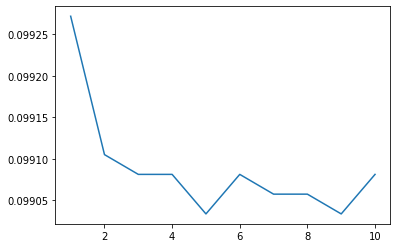

In [28]:
plt.plot([1,2,3,4,5,6,7,8,9,10],h['train_acc'])

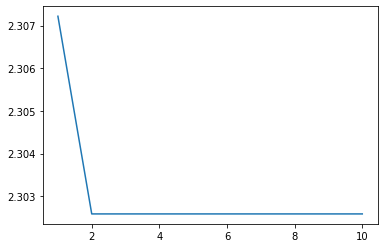

In [29]:
plt.plot([1,2,3,4,5,6,7,8,9,10],h['train_loss'])